# Szum w Etykietach Danych

![label_noise_intro.png](https://live.staticflickr.com/65535/54328952408_f7e5bcb7c9_z.jpg)

*Obraz wygenerowany przy użyciu modelu generatywnego z OpenArt.ai.*

## Wstęp

Kluczowe w uczeniu maszynowym są dane. Od nich wszystko się zaczyna. W praktyce jednak dane często nie są idealne i zawierają pewien szum zmieniejszający ich jakość. Jednym z rodzajów takiego szumu jest szum w etykietach danych, co oznacza, że dla niektórych obserwacji etykiety są niepoprawne.

Przyczyny szumu w etykietach mogą być zróżnicowane. Często wynikają one z subiektywności oceny – różni eksperci mogą mieć odmienne zdanie, np. oceniając emocje na zdjęciach lub jakość wypracowania. Innym źródłem błędów może być zmęczenie anotatorów, które wpływa na ich koncentrację i dokładność.

Niejasności mogą też wynikać ze słabej jakości danych, która utrudnia jednoznaczną klasyfikację (np. rozmyte zdjęcie psa, który przypomina wilka). Czasem etykiety bywają generowane automatycznie przez modele sztucznej inteligencji, które również mogą popełniać błędy.

Warto wspomnieć o próbkach znajdujących się na granicy klas. Takie przypadki, np. w danych medycznych, gdzie objawy są zbliżone dla różnych chorób, również prowadzą do trudności w przypisaniu jednoznacznej etykiety.

Zaszumienie danych utrudnia wytrenowanie modelu o dobrej jakości, ponieważ model może skupić się bardziej na niepoprawnych informacjach niż na ogólnych regułach w nich zawartych.

## Zadanie

Twoim zadaniem będzie wytrenowanie **dwóch** sieci neuronowych do poprawnej binarnej klasyfikacji obrazów pomimo częściowego zaszumienia etykiet w danych treningowych. Zbiór treningowy jest niezbalansowany (weź to pod uwagę w swoim rozwiązaniu). Zbiór walidacyjny jak i testowy (który będzie użyty do ewaluacji Twojego finalnego rozwiązania) mają tylko poprawne etykiety (bez szumu).

**Architektura modeli jest zdefiniowana i nie możesz jej zmieniać.**

Zastanów się dlaczego korzystamy z dwóch modeli a nie jednego (to jest pewna zagadka) - to pomoże Ci zrozumieć zadanie i je rozwiązać.
Twoją rolą w tym zadaniu jest zaimplementować funkcję `your_selected_indices(targets, losses)`, która wybierze indeksy danych ze zbioru treningowego, które zostaną wykorzystane do trenowania modeli. Funkcja przyjmuje na wejściu tensor z etykietami danych (`targets`) i tensor z wartościami funkcji straty z obu modeli (`losses`). Wynikiem tej funkcji powininna być dwuelementowa lista, gdzie elementami będą tensory zawierające indeksy wybrane do trenowania modeli. Jeden model otrzymuje jeden zestaw indeksów, drugi model otrzymuje drugi.
Poniżej w notatniku znajdziesz komórkę, w której znajduje się miejsce na Twoją funkcję. Komórka, którą powinieneś zmodyfikować jest wyraźnie oznaczona. Żeby lepiej zrozumieć jej działanie i cel warto zobaczyć kontekst i miejsce gdzie ta funkcja zostanie wywołana w pętli treningowej.

### Kryterium Oceny
Ostateczna ocena zadania będzie na podstawie średniej wartości zbalansowanej miary trafności (*ang. balanced accuracy, BAC*) z dwóch modeli tj. ${BAC}_{mean} = \frac{BAC_1+BAC_2}{2}$ gdzie $BAC_i$ to *balanced accuracy* dla modelu $i$, ($i = 1, 2$).

Za to zadanie możesz zdobyć pomiędzy 0 a 100 punktów.

Twój finalny wynik punktowy za rozwiązanie zadania obliczony będzie według poniższej funkcji (im wyższa wartość tym lepiej) przy dodatkowym zastosowaniu zakrąglenia do wartości całkowitych:
$$
\mathrm{Punkty} =
\begin{cases}
    0 & \text{jeżeli } {BAC}_{mean} \leq 0.5 \\
    100 \times \frac{{BAC}_{mean} - 0.5}{0.8 - 0.5} & \text{jeżeli } 0.5 < {BAC}_{mean} < 0.8 \\
    100 & \text{jeżeli } {BAC}_{mean} \geq 0.8
\end{cases}
$$

**Uwaga: Zauważ, że żeby zdobyć maksymalną ilość punktów nie ma konieczności osiągnięcia maksymalnej wartości *balanced accuracy* równej 1. Jeśli ${BAC}_{mean}$ będzie równe co najmniej 0.8, wówczas otrzymasz maksymalną liczbę punktów.**

To kryterium i wszystkie funkcje, o których mowa powyżej, są zaimplementowane poniżej przez nas.

## Ograniczenia

- Twoje rozwiazanie będzie testowane na Platformie Konkursowej bez dostępu do internetu oraz w środowisku z GPU.
- Ewaluacja Twojego finalnego rozwiązania na Platformie Konkursowej nie może trwać dłużej niż 5 minut z GPU.
- **Nie możesz** zmieniać architektury modeli - musi to być zdefiniowany przez nas `SmallMobileNet`.

## Pliki zgłoszeniowe
Ten notebook uzupełniony o Twoje rozwiązanie (patrz funkcja `your_selected_indices`).

## Ewaluacja
Pamiętaj, że podczas sprawdzania flaga `FINAL_EVALUATION_MODE` zostanie ustawiona na `True`.

Za to zadanie możesz zdobyć pomiędzy 0 a 100 punktów. Liczba punktów, którą zdobędziesz, będzie wyliczona na (tajnym) zbiorze testowym na Platformie Konkursowej na podstawie wyżej wspomnianego wzoru, zaokrąglona do liczby całkowitej. Jeśli Twoje rozwiązanie nie będzie spełniało powyższych kryteriów lub nie będzie wykonywać się prawidłowo, otrzymasz za zadanie 0 punktów.

# Kod Startowy
W tej sekcji inicjalizujemy środowisko poprzez zaimportowanie potrzebnych bibliotek i funkcji. Przygotowany kod ułatwi Tobie efektywne operowanie na danych i budowanie właściwego rozwiązania.

In [1]:
# W czasie sprawdzania Twojego rozwiązania, wartość flagi FINAL_EVALUATION_MODE zostanie zmieniona na True
FINAL_EVALUATION_MODE = False

In [2]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
import os
from tqdm import tqdm
from typing import Optional, Tuple, List

import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchvision.datasets.folder import VisionDataset

from sklearn.metrics import balanced_accuracy_score

## Funkcje i Stałe Pomocnicze

In [3]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
SEED = 123
IMAGES_DIR = "data"
TASK_DATASET_LABELS_FILE = "dataset_labels.csv"

ROOT_DIR = os.getcwd()
TRAIN_DATASET_PATH = os.path.join(ROOT_DIR,'train')
VAL_DATASET_PATH = os.path.join(ROOT_DIR, 'val')

TRAIN_DATASET_URL = "1qmNNmDv-wUcAv5mvO6vYJV3mQ2SNIGnI"
VAL_DATASET_URL = "1YUJYD12NmKRSzFJGMrX-a61d6mnTaWbG"

In [4]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-2
NUM_EPOCHS = 6
NUM_CLASSES = 2
BATCH_SIZE = 128
WEIGHT_DECAY = 1e-3

if not FINAL_EVALUATION_MODE:
  print(f"Using {DEVICE} device")

Using cuda device


In [5]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def seed_everything(seed: int) -> None:
    """
    Ustawia ziarno (seed) dla odtwarzalności wyników w Pythonie, NumPy oraz PyTorch.

    Funkcja ustawia ziarno dla generatorów liczb losowych Pythonie, NumPy oraz PyTorch,
    a także konfiguruje PyTorch do pracy w trybie deterministycznym.

    Parametry:
        seed (int): Wartość ziarna do ustawienia.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Ładowanie Danych
Za pomocą poniższego kodu dane zostaną wczytane i odpowiednio przygotowane.

In [6]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def download_data(dataset_path, dataset_url):
    """Pobiera zbiór danych z Google Drive Olimpiady i zapisuje go w folderze."""
    import gdown
    import shutil

    # Utwórz lub zresetuj folder
    output = dataset_path+".zip"
    if os.path.exists(dataset_path):
        shutil.rmtree(dataset_path)
    if os.path.exists(output):
        os.remove(output)

    url = f'https://drive.google.com/uc?id={dataset_url}'
    gdown.download(url, output, fuzzy=True)

    print(f"Downloaded: {output}")

# Pobierz dane tylko jeśli nie jesteś w trybie FINAL_EVALUATION_MODE
if not FINAL_EVALUATION_MODE:
    download_data(TRAIN_DATASET_PATH, TRAIN_DATASET_URL)
    download_data(VAL_DATASET_PATH, VAL_DATASET_URL)

Downloading...
From (original): https://drive.google.com/uc?id=1qmNNmDv-wUcAv5mvO6vYJV3mQ2SNIGnI
From (redirected): https://drive.google.com/uc?id=1qmNNmDv-wUcAv5mvO6vYJV3mQ2SNIGnI&confirm=t&uuid=7bb612da-6cec-4f21-ace9-83599fefbd3f
To: /content/train.zip
100%|██████████| 11.9M/11.9M [00:00<00:00, 29.7MB/s]


Downloaded: /content/train.zip


Downloading...
From: https://drive.google.com/uc?id=1YUJYD12NmKRSzFJGMrX-a61d6mnTaWbG
To: /content/val.zip
100%|██████████| 1.19M/1.19M [00:00<00:00, 110MB/s]

Downloaded: /content/val.zip


In [7]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Klasa zbioru danych
class TaskDataset(VisionDataset):
    def __init__(
        self,
        root: str,
        transform: Optional[callable] = None,
    ):
        super().__init__(
            root,
            transform=transform,
        )
        self.root = root

        if not self._check_integrity():
            raise RuntimeError(
                f"Nie znaleziono zbioru danych. Sprawdź czy ścieżka {self.root} istnieje. Powinna ona zwierać folder '{IMAGES_DIR}' i plik '{TASK_DATASET_LABELS_FILE}' file"
            )
        self.labels_df = self._read_labels_from_file()
        self.labels_header = 'label'

    def _read_labels_from_file(self) -> pd.DataFrame:
        df = pd.read_csv(os.path.join(self.root, TASK_DATASET_LABELS_FILE))
        return df

    def _check_integrity(self) -> bool:
        return os.path.exists(os.path.join(self.root, IMAGES_DIR)) and os.path.exists(
            os.path.join(self.root, TASK_DATASET_LABELS_FILE)
        )

    def __len__(self) -> int:
        return len(self.labels_df)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, np.ndarray]:
        img = self._load_image(idx)
        label = self._load_label(idx)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def _load_image(self, idx: int) -> Image.Image:
        img_path = os.path.join(
            self.root, IMAGES_DIR, self.labels_df.iloc[idx]['file_name']
        )
        img = Image.open(img_path)
        return img

    def _load_label(self, idx: int):
        label = self.labels_df.iloc[idx][self.labels_header]
        return np.array([int(label)])

In [8]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def unpack_data(unpack_path, dataset_name) -> None:
    dataset_zip_path = os.path.join(ROOT_DIR, dataset_name+".zip")
    dataset_local_dir = os.path.join(unpack_path, dataset_name)
    if not os.path.exists(dataset_local_dir):
        if not os.path.exists(dataset_zip_path):
            raise FileNotFoundError(
                f"Nie znaleziono pliku {dataset_zip_path} w bieżącym folderze."
            )

        with zipfile.ZipFile(dataset_zip_path, "r") as zip_ref:
            zip_ref.extractall(unpack_path)

In [9]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# Funkcja ładująca dane treningowe i walidacyjne
def load_data() -> Tuple[DataLoader, DataLoader]:
    """
    Funkcja ładująca dane treningowe i walidacyjne przy użyciu klasy TaskDataset.

    Funkcja tworzy zbiory danych dla danych treningowych oraz walidacyjnych,
    stosuje podstawową transformację (konwersję do tensora), a następnie
    opakowuje je w obiekty DataLoader.

    Zwraca:
        Tuple[DataLoader, DataLoader]: Obiekty DataLoader dla zbioru treningowego oraz walidacyjnego.
    """
    base_transform = transforms.Compose([transforms.ToTensor()])

    train_dataset = TaskDataset(root=TRAIN_DATASET_PATH, transform=base_transform)
    val_dataset = TaskDataset(root=VAL_DATASET_PATH, transform=base_transform)

    train_loader = DataLoader(
        dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False
    )
    val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader

In [10]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# Rozpakujmy i załadujmy dane
if not FINAL_EVALUATION_MODE:
    unpack_data(ROOT_DIR, "train")
    unpack_data(ROOT_DIR, "val")
    train_loader, val_loader = load_data()

## Architektura Modelu

In [11]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
class SmallMobileNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SmallMobileNet, self).__init__()

        # Główne bloki konwolucyjne
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
            nn.Conv2d(
                32, 32, kernel_size=3, stride=1, padding=1, groups=32, bias=False
            ),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
            nn.Conv2d(32, 64, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),
            nn.Conv2d(
                64, 64, kernel_size=3, stride=2, padding=1, groups=64, bias=False
            ),
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),
            nn.Conv2d(64, 128, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU6(inplace=True),
            nn.Conv2d(
                128, 128, kernel_size=3, stride=2, padding=1, groups=128, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU6(inplace=True),
            nn.Conv2d(128, 256, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU6(inplace=True),
        )

        self.pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU6(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Kod z Kryterium Oceniającym

Kod, zbliżony do poniższego, będzie używany do oceny rozwiązania na zbiorze testowym.

In [12]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def predict_and_evaluate(model, val_loader, device, verbose=False):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    balanced_accuracy = balanced_accuracy_score(all_targets, all_preds)

    if verbose:
        print(f"Balanced Accuracy: {balanced_accuracy}")

    return balanced_accuracy

In [13]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def performance(bac_1: float, bac_2: float) -> None:
    """
    Oblicza i wypisuje wynik wydajności na podstawie dwóch wartości balanced accuracy.

    Ostateczny wynik to średnia z obu wartości, przeskalowana między ustalonymi granicami,
    co przekłada się na liczbę zdobytych punktów.

    Parametry:
        bac_1 (float): Wartość balanced accuracy dla pierwszego modelu.
        bac_2 (float): Wartość balanced accuracy dla drugiego modelu.
    """
    bac_mean = (bac_1 + bac_2) / 2
    if bac_mean <= 0.5:
        points = 0
    elif 0.5 < bac_mean < 0.8:
        points = (bac_mean - 0.5) / (0.8 - 0.5) * 100
        points = int(round(points))
    else:
        points = 100

    print(
        f"Twoje rozwiązanie ma średnią wartość balanced accuracy równą {round(bac_mean, 5)} na zbiorze walidacyjnym, co daje {points}/100 punktów."
    )
    return points

## Trening Modelu

In [14]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################


# Funkcja do trenowania modelu
def train(
    model1,
    model2,
    optimizer1,
    optimizer2,
    criterion,
    train_loader,
    val_loader,
    num_epochs,
    device,
    select_indices_fn,
):

    verbose = False if FINAL_EVALUATION_MODE else True

    # Historia metryk dla każdego modelu
    metrics = {
        k: [[], []]
        for k in [
            "train_loss",
            "val_loss",
            "train_bac",
            "val_bac",
        ]
    }
    epochs_range = np.arange(num_epochs) + 1

    # Główna pętla treningowa
    for epoch in epochs_range:
        print(f"Epoch {epoch}")

        # Historia statystyk dla każdego modelu
        stats = {
            k: [0, 0] for k in ["train_loss", "train_total", "val_loss", "val_total"]
        }
        preds_targets = {
            k: [[], []]
            for k in ["train_preds", "train_targets", "val_preds", "val_targets"]
        }

        model1.train(), model2.train()
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.squeeze().long().to(device)

            outputs = [m(inputs) for m in (model1, model2)]
            losses = [criterion(out, targets) for out in outputs]

            # --- GŁÓWNY PUNKT ZADANIA ---
            selected_indices = select_indices_fn(targets, losses)
            # ---------------------------

            # Propagacja wsteczna dla każdego modelu
            for i, (model, optim) in enumerate(
                [(model1, optimizer1), (model2, optimizer2)]
            ):
                optim.zero_grad()
                sel_idx = selected_indices[i]
                loss = criterion(model(inputs[sel_idx]), targets[sel_idx]).mean()

                loss.backward()
                optim.step()

                # Historia statystyk
                stats["train_loss"][i] += loss.item() * len(sel_idx)
                stats["train_total"][i] += len(sel_idx)
                preds = outputs[i].max(1)[1]
                preds_targets["train_preds"][i].extend(preds[sel_idx].cpu().numpy())
                preds_targets["train_targets"][i].extend(targets[sel_idx].cpu().numpy())

        # Ewaluacja na zbiorze walidacyjnym
        if verbose:
            model1.eval(), model2.eval()
            with torch.no_grad():
                for inputs, targets in tqdm(
                    val_loader, desc=f"Validation {epoch}/{num_epochs}"
                ):
                    inputs, targets = inputs.to(device), targets.squeeze().long().to(
                        device
                    )

                    for i, model in enumerate([model1, model2]):
                        outputs = model(inputs)
                        loss = criterion(outputs, targets).mean()
                        preds = outputs.max(1)[1]

                        stats["val_loss"][i] += loss.item() * inputs.size(0)
                        stats["val_total"][i] += inputs.size(0)
                        preds = outputs.max(1)[1]
                        preds_targets["val_preds"][i].extend(preds.cpu().numpy())
                        preds_targets["val_targets"][i].extend(targets.cpu().numpy())

        # Obliczanie metryk
        if verbose:
            models = [model1, model2]
            for i in range(2):
                for phase in ["train", "val"]:
                    preds = preds_targets[f"{phase}_preds"][i]
                    targets = preds_targets[f"{phase}_targets"][i]

                    metrics[f"{phase}_loss"][i].append(
                        stats[f"{phase}_loss"][i] / stats[f"{phase}_total"][i]
                    )
                    metrics[f"{phase}_bac"][i].append(
                        balanced_accuracy_score(targets, preds)
                    )

                print(
                    f"Model{i+1} - Train Loss: {metrics['train_loss'][i][-1]:.4f}, "
                    f"Train balanced accuracy: {metrics['train_bac'][i][-1]:.4f} --- "
                    f"Validation Loss: {metrics['val_loss'][i][-1]:.4f}, "
                    f"Validation balanced accuracy: {metrics['val_bac'][i][-1]:.4f}, "
                )

    # Generowanie wykresów
    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        colors = ["#fa2729", "#ac1a1c", "#1a6aff", "#144aad"]
        linestyles = ["-", "--"]

        for i, model_name in enumerate(["Model1", "Model2"]):
            for j, phase in enumerate(["train", "val"]):

                color = colors[i * 2 + j]
                ax1.plot(
                    epochs_range,
                    metrics[f"{phase}_loss"][i],
                    color=color,
                    marker="o",
                    linestyle=linestyles[j],
                    label=f"{model_name} {phase.title()} Loss",
                )
                ax2.plot(
                    epochs_range,
                    metrics[f"{phase}_bac"][i],
                    color=color,
                    marker="o",
                    linestyle=linestyles[j],
                    label=f"{model_name} {phase.title()} balanced accuracy",
                )

        for ax, title in zip([ax1, ax2], ["Loss", "Balanced accuracy"]):
            ax.set_title(f"Training and Validation {title}")
            ax.set_xticks(epochs_range)
            ax.set_xlabel("Epochs")
            ax.set_ylabel(title)
            ax.legend()

        plt.tight_layout()
        plt.show()

## Przykładowe Rozwiązanie
Poniżej przedstawiamy uproszczone rozwiązanie, które służy jako przykład demonstrujący podstawową funkcjonalność notatnika. Może ono posłużyć jako punkt wyjścia do opracowania Twojego rozwiązania.

In [15]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def default_select_indices(targets, losses):
    # Wszystkie indeksy dla obu modeli
    selected_indices = [torch.arange(targets.shape[0]).to(DEVICE) for _ in range(2)]
    return selected_indices

Epoch 1


Validation 1/6: 100%|██████████| 8/8 [00:00<00:00,  9.35it/s]


Model1 - Train Loss: 0.6398, Train balanced accuracy: 0.5020 --- Validation Loss: 0.7998, Validation balanced accuracy: 0.5000, 
Model2 - Train Loss: 0.6396, Train balanced accuracy: 0.5031 --- Validation Loss: 0.6857, Validation balanced accuracy: 0.5000, 
Epoch 2


Validation 2/6: 100%|██████████| 8/8 [00:00<00:00, 15.67it/s]


Model1 - Train Loss: 0.5997, Train balanced accuracy: 0.5006 --- Validation Loss: 0.7056, Validation balanced accuracy: 0.5000, 
Model2 - Train Loss: 0.5975, Train balanced accuracy: 0.5113 --- Validation Loss: 0.6499, Validation balanced accuracy: 0.5000, 
Epoch 3


Validation 3/6: 100%|██████████| 8/8 [00:00<00:00, 15.78it/s]


Model1 - Train Loss: 0.5803, Train balanced accuracy: 0.5008 --- Validation Loss: 0.6637, Validation balanced accuracy: 0.5000, 
Model2 - Train Loss: 0.5889, Train balanced accuracy: 0.5092 --- Validation Loss: 0.6660, Validation balanced accuracy: 0.5000, 
Epoch 4


Validation 4/6: 100%|██████████| 8/8 [00:00<00:00, 16.10it/s]


Model1 - Train Loss: 0.5867, Train balanced accuracy: 0.5000 --- Validation Loss: 1.1048, Validation balanced accuracy: 0.5000, 
Model2 - Train Loss: 0.5742, Train balanced accuracy: 0.4999 --- Validation Loss: 0.9236, Validation balanced accuracy: 0.5000, 
Epoch 5


Validation 5/6: 100%|██████████| 8/8 [00:00<00:00, 15.55it/s]


Model1 - Train Loss: 0.5668, Train balanced accuracy: 0.5018 --- Validation Loss: 0.9301, Validation balanced accuracy: 0.5000, 
Model2 - Train Loss: 0.5686, Train balanced accuracy: 0.5000 --- Validation Loss: 0.6992, Validation balanced accuracy: 0.5000, 
Epoch 6


Validation 6/6: 100%|██████████| 8/8 [00:00<00:00, 15.42it/s]


Model1 - Train Loss: 0.5689, Train balanced accuracy: 0.5000 --- Validation Loss: 1.1093, Validation balanced accuracy: 0.5000, 
Model2 - Train Loss: 0.5629, Train balanced accuracy: 0.5000 --- Validation Loss: 0.7231, Validation balanced accuracy: 0.5000, 


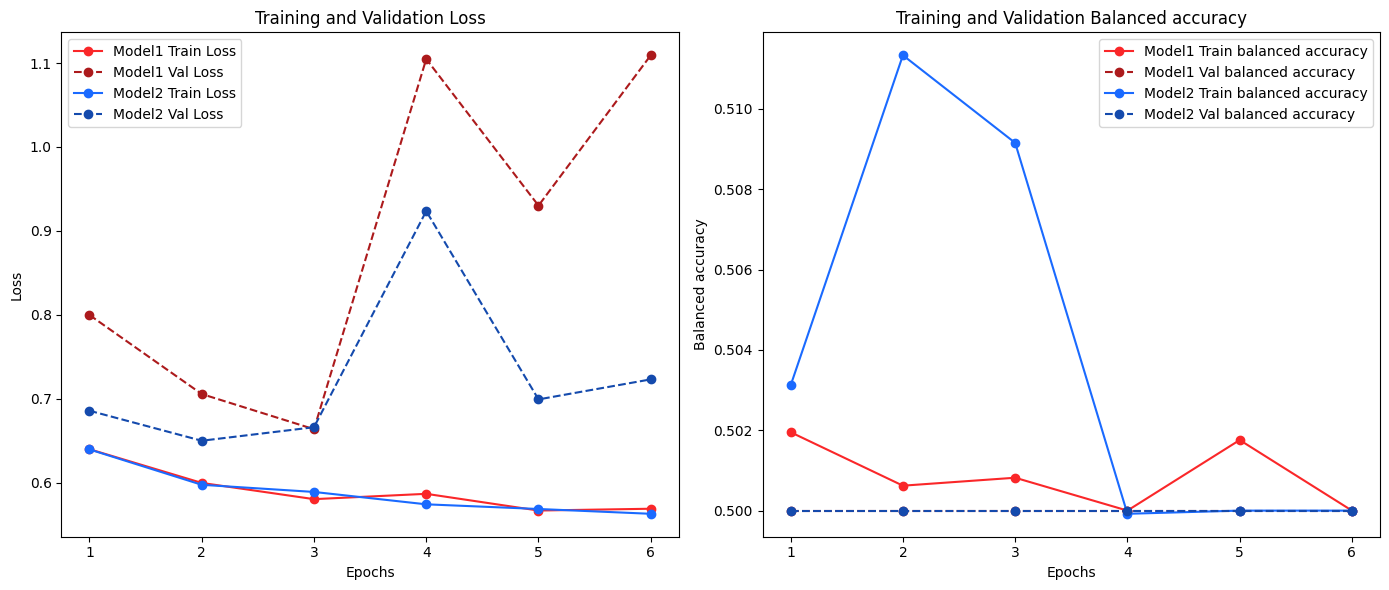

Balanced Accuracy: 0.5
Balanced Accuracy: 0.5
Twoje rozwiązanie ma średnią wartość balanced accuracy równą 0.5 na zbiorze walidacyjnym, co daje 0/100 punktów.


In [16]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# WAŻNE: Trenujemy zawsze dwa modele i ewaluujemy

if not FINAL_EVALUATION_MODE:
    seed_everything(SEED)
    criterion = nn.CrossEntropyLoss(reduction="none")

    model1 = SmallMobileNet(NUM_CLASSES).to(DEVICE)
    model2 = SmallMobileNet(NUM_CLASSES).to(DEVICE)

    optimizer1 = AdamW(model1.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    optimizer2 = AdamW(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    seed_everything(SEED)
    train(
        model1,
        model2,
        optimizer1,
        optimizer2,
        criterion,
        train_loader,
        val_loader,
        NUM_EPOCHS,
        DEVICE,
        select_indices_fn=default_select_indices,
    )

    # Ewaluacja przykładowego rozwiązania
    bac_1 = predict_and_evaluate(model1, val_loader, DEVICE, verbose=True)
    bac_2 = predict_and_evaluate(model2, val_loader, DEVICE, verbose=True)

    performance(bac_1, bac_2)

# Twoje Rozwiązanie
W tej sekcji należy umieścić Twoje rozwiązanie. Wprowadzaj zmiany wyłącznie tutaj!

Aktualnie startowym rozwiązaniem jest to przykładowe. Twoim zadaniem jest zmodyfikowanie wnętrza (ciała) funkcji. W rozwiązaniu nie korzystaj z `default_select_indices`.

In [17]:
def your_select_indices(
    targets: torch.Tensor, losses: List[torch.Tensor],
) -> List[torch.Tensor]:
    """
    Implementacja Co-teaching z uwzględnieniem niezbalansowania klas.

    Parametry:
        targets: Tensor etykiet (batch_size,).
        losses: Lista dwóch tensorów strat dla poszczególnych modeli (batch_size,).

    Zwraca:
        Lista dwóch tensorów indeksów wybranych do trenowania modeli.
    """
    batch_size = targets.shape[0]
    retain_ratio = 0.9
    class_zero_retain_percent = 0.58

    num_selected = int(retain_ratio * batch_size)

    indices_class_0 = (targets == 0).nonzero(as_tuple=True)[0]
    indices_class_1 = (targets == 1).nonzero(as_tuple=True)[0]

    sorted_0_model1 = indices_class_0[torch.argsort(losses[0][indices_class_0])]
    sorted_1_model1 = indices_class_1[torch.argsort(losses[0][indices_class_1])]

    sorted_0_model2 = indices_class_0[torch.argsort(losses[1][indices_class_0])]
    sorted_1_model2 = indices_class_1[torch.argsort(losses[1][indices_class_1])]

    num_selected_0 = int(num_selected * class_zero_retain_percent)
    num_selected_1 = num_selected - num_selected_0

    selected_0_model1 = sorted_0_model1[:num_selected_0]
    selected_1_model1 = sorted_1_model1[:num_selected_1]
    selected_indices_1 = torch.cat([selected_0_model1, selected_1_model1])

    selected_0_model2 = sorted_0_model2[:num_selected_0]
    selected_1_model2 = sorted_1_model2[:num_selected_1]
    selected_indices_2 = torch.cat([selected_0_model2, selected_1_model2])

    return [selected_indices_2, selected_indices_1]


# Ewaluacja

Uruchomienie poniższych komórek pozwoli sprawdzić, ile punktów zdobyłoby Twoje rozwiązanie na danych walidacyjnych. Przed wysłaniem upewnij się, że cały notebook (również z ustawioną flagą `FINAL_EVALUATION_MODE = True`) wykonuje się od początku do końca bez błędów i bez konieczności ingerencji użytkownika po wybraniu opcji "Run All".


In [18]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def final_evaluate(evaluate_data_path, model1, model2):

    base_transform = transforms.Compose([transforms.ToTensor()])
    evaluate_dataset = TaskDataset(root=evaluate_data_path, transform=base_transform)
    evaluate_loader = DataLoader(
        dataset=evaluate_dataset, batch_size=BATCH_SIZE, shuffle=False
    )

    bac_1 = predict_and_evaluate(model1, evaluate_loader, DEVICE, verbose=True)
    bac_2 = predict_and_evaluate(model2, evaluate_loader, DEVICE, verbose=True)
    return performance(bac_1, bac_2)

Epoch 1


Validation 1/6: 100%|██████████| 8/8 [00:00<00:00, 15.79it/s]


Model1 - Train Loss: 0.6108, Train balanced accuracy: 0.6267 --- Validation Loss: 0.9388, Validation balanced accuracy: 0.6661, 
Model2 - Train Loss: 0.6168, Train balanced accuracy: 0.5999 --- Validation Loss: 1.1602, Validation balanced accuracy: 0.5798, 
Epoch 2


Validation 2/6: 100%|██████████| 8/8 [00:00<00:00, 16.13it/s]


Model1 - Train Loss: 0.5521, Train balanced accuracy: 0.6916 --- Validation Loss: 0.4589, Validation balanced accuracy: 0.8262, 
Model2 - Train Loss: 0.5560, Train balanced accuracy: 0.6899 --- Validation Loss: 0.8363, Validation balanced accuracy: 0.6635, 
Epoch 3


Validation 3/6: 100%|██████████| 8/8 [00:00<00:00, 15.95it/s]


Model1 - Train Loss: 0.5285, Train balanced accuracy: 0.7086 --- Validation Loss: 0.4021, Validation balanced accuracy: 0.8847, 
Model2 - Train Loss: 0.5343, Train balanced accuracy: 0.7023 --- Validation Loss: 1.2137, Validation balanced accuracy: 0.7187, 
Epoch 4


Validation 4/6: 100%|██████████| 8/8 [00:00<00:00, 15.79it/s]


Model1 - Train Loss: 0.5245, Train balanced accuracy: 0.7134 --- Validation Loss: 0.5893, Validation balanced accuracy: 0.7665, 
Model2 - Train Loss: 0.5250, Train balanced accuracy: 0.7184 --- Validation Loss: 0.7757, Validation balanced accuracy: 0.7625, 
Epoch 5


Validation 5/6: 100%|██████████| 8/8 [00:00<00:00, 12.96it/s]


Model1 - Train Loss: 0.5030, Train balanced accuracy: 0.7190 --- Validation Loss: 0.7109, Validation balanced accuracy: 0.7725, 
Model2 - Train Loss: 0.5103, Train balanced accuracy: 0.7141 --- Validation Loss: 0.6786, Validation balanced accuracy: 0.8344, 
Epoch 6


Validation 6/6: 100%|██████████| 8/8 [00:00<00:00, 15.96it/s]


Model1 - Train Loss: 0.5039, Train balanced accuracy: 0.7154 --- Validation Loss: 0.5604, Validation balanced accuracy: 0.8788, 
Model2 - Train Loss: 0.5083, Train balanced accuracy: 0.7201 --- Validation Loss: 0.5107, Validation balanced accuracy: 0.8848, 


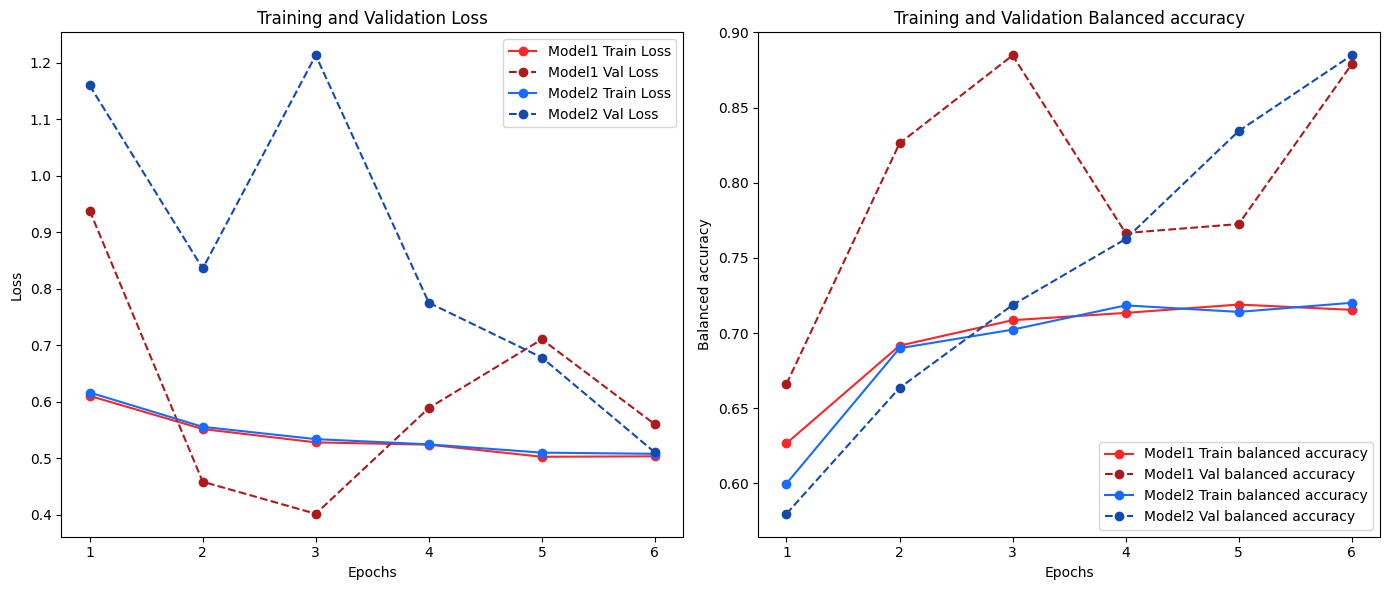

Balanced Accuracy: 0.8787963280713795
Balanced Accuracy: 0.8847589224433768
Twoje rozwiązanie ma średnią wartość balanced accuracy równą 0.88178 na zbiorze walidacyjnym, co daje 100/100 punktów.


In [19]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
if not FINAL_EVALUATION_MODE:
    seed_everything(SEED)
    criterion = nn.CrossEntropyLoss(reduction="none")

    model1 = SmallMobileNet(NUM_CLASSES).to(DEVICE)
    model2 = SmallMobileNet(NUM_CLASSES).to(DEVICE)

    optimizer1 = AdamW(model1.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    optimizer2 = AdamW(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    seed_everything(SEED)
    train(
        model1,
        model2,
        optimizer1,
        optimizer2,
        criterion,
        train_loader,
        val_loader,
        NUM_EPOCHS,
        DEVICE,
        select_indices_fn=your_select_indices,
    )

    final_evaluate(VAL_DATASET_PATH, model1, model2)

Twoja funkcja `your_select_indices` zostanie zapisana do pliku `your_select_indices.pkl`, a następnie wykorzystana do trenowania modeli na zbiorze treningowym (zgodnie z powyższym kodem). Finalna liczba punktów zostanie wyliczona na podstawie jakości klasyfikacji na zbiorze testowym.

In [21]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
if FINAL_EVALUATION_MODE:
    import cloudpickle

    OUTPUT_PATH = "file_output"
    FUNCTION_FILENAME = "your_select_indices.pkl"
    FUNCTION_OUTPUT_PATH = os.path.join(OUTPUT_PATH, FUNCTION_FILENAME)

    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    with open(FUNCTION_OUTPUT_PATH, "wb") as f:
        cloudpickle.dump(your_select_indices, f)